##### Master Degree in Computer Science and Data Science for Economics

# Classification by RNN

### Alfio Ferrara

You can also see the [Tutorial PyTorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial).

## Data preparation

In [39]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [40]:
folder = '../'
classification_path = '{}/data/roman_number-classification.csv'.format(folder)
data = pd.read_csv(classification_path)

In [41]:
data.head(2)

,sequence,target
0,___CXXXIII,odd
1,____CXCVII,odd


We build a dictionary `{'category': [list of numbers]}`

As categories, we split the numbers between first and second half of the decade

In [42]:
from roman_arabic_numerals import conv

def get_label(num):
    k = int(str(conv.rom_arab(num))[-1])
    if k < 5:
        return 'first'
    else:
        return 'second'

In [45]:
get_label('IV')

'first'

In [46]:
sequences = data.sequence.values 
targets = data.target.values 
vocabulary = set()
category_lines = {'first': [], 'second': []}
for i, seq in enumerate(sequences):
    n = seq.replace('_', '')
    for c in n:
        vocabulary.add(c)
    category_lines[get_label(n)].append(n)
vocabulary = sorted(list(vocabulary))
categories = list(category_lines.keys())

In [47]:
vocabulary

['C', 'I', 'L', 'V', 'X']

## Convert numbers in tensors
Each character is represented using *One-Hot encoding*

Turn a line into a `<line_length x 1 x n_letters>`

In [48]:
import torch 

In [49]:
def num2tensor(num):
    tensor = torch.zeros(len(num), 1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[li][0][vocabulary.index(letter)] = 1
    return tensor

In [51]:
num2tensor('XII')

tensor([[[0., 0., 0., 0., 1.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]]])

## RNN from scratch

In [52]:
import nlp.neurnets as nt 

In [54]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
rnn = nt.RNN(input_size, n_hidden, output_size)

### Prediction with no training

In [55]:
input_example = num2tensor('IX')
hidden_example = torch.zeros(1, n_hidden)
with torch.no_grad():
    output, next_hidden = rnn(input_example[0], hidden_example)
    print(output)

tensor([[-0.8825, -0.5340]])


## Training

In [56]:
import torch.nn as nn

### Utility functions

In [57]:
def read_categories(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

print(read_categories(output))

('second', 1)


Random construction of a training set:

In [58]:
def random_training_sample(embedding_function: callable):
    category = np.random.choice(categories)
    line = np.random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
    line_tensor = embedding_function(line)
    return category, line, category_tensor, line_tensor

In [59]:
for i in range(6):
    c, n, _, _ = random_training_sample(num2tensor)
    print(n, c)

CCV second
CVI second
CLX first
XLII first
XCVI second
CXIII first


In [60]:
print(vocabulary)

['C', 'I', 'L', 'V', 'X']


## Training and error plot

In [61]:
input_size = len(vocabulary)
n_hidden = 16
output_size = len(categories)
rnn = nt.RNN(input_size, n_hidden, output_size)

In [62]:
n_iterations = 10000
plot_every = 100
history = rnn.run_training(data_generator=random_training_sample, embedding_function=num2tensor, 
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:03<00:00, 2933.99it/s]


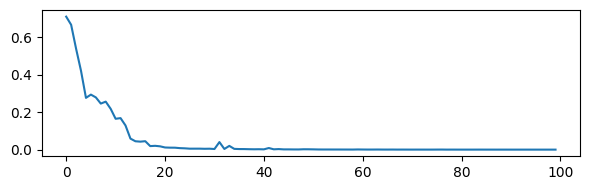

In [63]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

## Evaluation

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter 

In [65]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = rnn.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

['second', 'second', 'second'] ['second', 'second', 'second']


In [66]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       first       1.00      1.00      1.00       515
      second       1.00      1.00      1.00       485

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### Comparison with BOW
Let's create a neural network that maps a BOW (One-Hot) representation of the sequence as a whole into a classes vector. Let's also use a hidden layer.

In [67]:
def num2bow(num):
    tensor = torch.zeros(1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[0][vocabulary.index(letter)] += 1
    return tensor

In [68]:
input_dim = len(vocabulary)
hidden_dim = 16
output_dim = len(categories)
learning_rate = 0.005
bow = nt.FrequencyPredictor(input_dim, hidden_dim, output_dim)

### Training

In [69]:
n_iterations = 10000
plot_every = 100
history = bow.run_training(data_generator=random_training_sample, embedding_function=num2bow, 
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:01<00:00, 5505.39it/s]


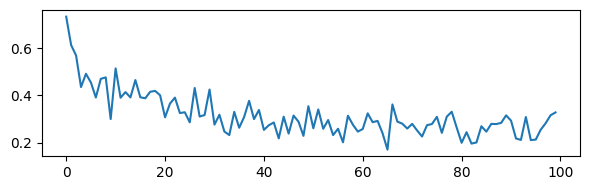

In [70]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

In [71]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2bow)
    output = bow.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

['first', 'first', 'first'] ['first', 'first', 'first']


In [72]:
print(classification_report(y_true, y_pred, zero_division=0))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

       first       0.76      0.93      0.84       513
      second       0.91      0.70      0.79       487

    accuracy                           0.82      1000
   macro avg       0.84      0.81      0.81      1000
weighted avg       0.83      0.82      0.82      1000

[[478  35]
 [147 340]]


## Fake RNN
This network is identical to the RNN but it does not propagate the information in the hidden layer to the final layer.

In [73]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
fake = nt.FakeRNN(input_size, n_hidden, output_size)

In [74]:
input_example = num2tensor('IX')
hidden_example = torch.zeros(1, n_hidden)
with torch.no_grad():
    output, next_hidden = fake(input_example[0], hidden_example)
    print(output)

tensor([[-0.5869, -0.8121]])


In [75]:
n_iterations = 10000
plot_every = 100
history = fake.run_training(data_generator=random_training_sample, embedding_function=num2tensor, 
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:02<00:00, 4348.41it/s]


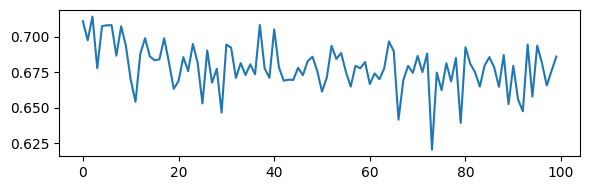

In [76]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

### Valutazione

In [77]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = fake.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

['second', 'first', 'second'] ['first', 'first', 'first']


In [78]:
print(classification_report(y_true, y_pred, zero_division=0))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

       first       0.51      0.87      0.64       493
      second       0.60      0.20      0.30       507

    accuracy                           0.53      1000
   macro avg       0.56      0.53      0.47      1000
weighted avg       0.56      0.53      0.47      1000

[[428  65]
 [408  99]]


## Example

In [79]:
example = ['VI', 'IV']
models = [(num2tensor, rnn, 'RNN'), (num2bow, bow, 'BOW'), (num2tensor, fake, 'FAKE')]
for n in example:
    for f, m, name in models:
        output = m.predict(f(n))
        c, i = read_categories(output=output)
        print(name, n, c)

RNN VI second
BOW VI second
FAKE VI first
RNN IV first
BOW IV second
FAKE IV first


In [38]:
print("BOW")
with torch.no_grad():
    print(np.exp(bow(num2bow('VI')).numpy()))
    print(np.exp(bow(num2bow('IV')).numpy()))
    
print("\nFAKE")
with torch.no_grad():
    print(np.exp(fake.predict(num2tensor('X')).numpy()))
    print(np.exp(fake.predict(num2tensor('IX')).numpy()))
    
print("\nRNN")
with torch.no_grad():
    print(np.exp(rnn.predict(num2tensor('VI')).numpy()))
    print(np.exp(rnn.predict(num2tensor('IV')).numpy()))

BOW
[[0.23737337 0.7626266 ]]
[[0.23737337 0.7626266 ]]

FAKE
[[0.4401575 0.5598425]]
[[0.4401575 0.5598425]]

RNN
[[2.1242174e-06 9.9999785e-01]]
[[9.9991024e-01 8.9747358e-05]]
